In [2]:
from imports import *

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [19]:
import data_management
from data_management import load_stack
from data_management import load_data

import interactive_plot

import metrics
from metrics import statistics
from metrics import confusion_matrix
from metrics import error_distribution
from metrics import error_borders
from metrics import PR_curve

import generator_extended

import unet
from unet import load_model_unet
from unet import predict_net
from unet import get_unet
from unet import train
from unet import execute_predict

### Load data

In [9]:
#training
imgs_train, imgs_mask_train = load_data(['/Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/data/mitochondria/dataset-epfl/epfl_train'], 
                                        ['/Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/data/mitochondria/dataset-epfl/epfl_train_gt'])

  0%|          | 0/1 [00:00<?, ?it/s]

found 165 images in /Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/data/mitochondria/dataset-epfl/epfl_train
found 165 in total.


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

(165, 768, 1024, 1)
(165, 768, 1024, 1)


In [10]:
#testing
imgs_test, imgs_mask_test = load_data(['/Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/data/mitochondria/dataset-epfl/epfl_test'], 
                                      ['/Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/data/mitochondria/dataset-epfl/epfl_test_gt'])

  0%|          | 0/1 [00:00<?, ?it/s]

found 165 images in /Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/data/mitochondria/dataset-epfl/epfl_test
found 165 in total.


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

(165, 768, 1024, 1)
(165, 768, 1024, 1)


In [11]:
print(imgs_train.min(), imgs_train.max())
print(imgs_mask_train.min(), imgs_mask_train.max())
print(imgs_test.min(), imgs_test.max())
print(imgs_mask_test.min(), imgs_mask_test.max())

0.08627451 0.95686275
0.0 1.0
0.007843138 1.0
0.0 1.0


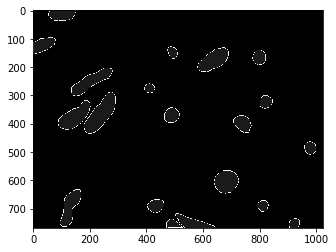

In [12]:
plt.figure(figsize=(7,4))
plt.imshow(imgs_mask_test[0,:,:,0], cmap='gray')
bimg = mh.borders(imgs_mask_test[0,:,:,0]).astype(int)
res = plt.imshow(bimg, alpha=0.9, cmap='gray')

### Run Training

In [13]:
model = get_unet(0.0005, 512, 512, dr_rate=0.2, diceloss=False, jaccardloss=False, 
                 focalloss=False, customloss=False, start_filters=16)

start_filters 16
conv1 shape: (?, 512, 512, 16)
conv1 shape: (?, 512, 512, 16)
pool1 shape: (?, 256, 256, 16)
conv2 shape: (?, 256, 256, 32)
conv2 shape: (?, 256, 256, 32)
pool2 shape: (?, 128, 128, 32)
conv3 shape: (?, 128, 128, 64)
conv3 shape: (?, 128, 128, 64)
pool3 shape: (?, 64, 64, 64)


In [21]:
model = load_model_unet('/Users/Vincent/Documents/Studium/Spring 2018 Courses/CS299r Independent Study/vincent/models/lucchi/weights.415-0.02.hdf5', 
                        use_dice_loss=False, use_jaccard_loss=False, use_focal_loss=False)

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
train(model, imgs_train, imgs_mask_train, imgs_test, imgs_mask_test,
      'models/model-newtrainset-d01-ensemble-larger-larger', 4, 1000, verbosity=1, 
      perform_flipping=True, perform_rotation=True, to_dir=False, train_on_borders=False)


### Evaluate

In [23]:
pred = execute_predict(model, imgs_test, stepsize=512, resize_shortest=True, extensive=False)

100%|██████████| 165/165 [00:00<00:00, 1815.14it/s]


165/165 [==============================] - 123s 748ms/step
1 of 2
165/165 [==============================] - 122s 738ms/step
2 of 2


In [24]:
np.save('predictions.npy', pred)

In [26]:
cmatrix = confusion_matrix(pred, imgs_mask_test)

In [28]:
statistics(cmatrix)

{'accuracy': 0.9925665576048571,
 'jaccard_background': 0.992178129619886,
 'jaccard_foreground': 0.8698003905557692,
 'precision': 0.9253308561513662,
 'recall': 0.9354584801131868,
 'voc_score': 0.9309892600878276}

In [ ]:
error_distribution(model, imgs_test, imgs_mask_test, extensive=True, figsize=(15,10))

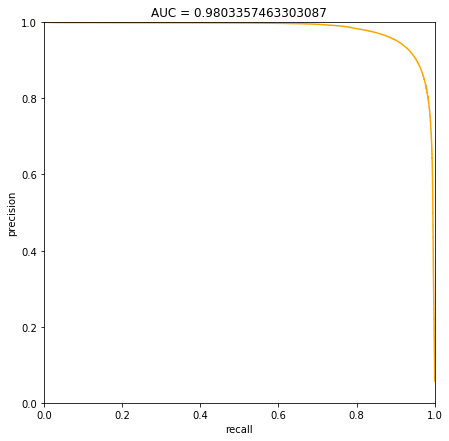

In [31]:
PR_curve(pred, imgs_mask_test)

### Results On Single Image

In [ ]:
use_train = False
imgnr = 60
input_img = cv2.imread('/n/regal/pfister_lab/vincent/vcasser/connectomics/movements/epfl-' + ('train' if use_train else 'test') + '-crop/' + str(imgnr) + '.png',0) 
gt = misc.imread('/n/regal/pfister_lab/vincent/vcasser/connectomics/movements/epfl-' + ('train' if use_train else 'test') + '-crop-mask/' + str(imgnr) + '.png')
print(gt.shape)

plt.figure(figsize = (15,15))
plt.imshow(input_img, cmap='gray')

print(input_img.shape)
res = execute_predict(model, input_img.reshape(1,512,512,1).astype(float)/255.)
print(res.min(), res.max())

res[res>0.5]=1
res[res<=0.5]=0

plt.figure(figsize = (15,15))
plt.imshow(res[0,:,:,0], cmap='gray')

plt.figure(figsize = (15,15))
plt.imshow(gt[:,:,0], cmap='gray')

cv2.imwrite('example_img_gt.png', gt)
cv2.imwrite('example_img_raw.png', input_img)
cv2.imwrite('example_img.png', res[0,:,:,0]*255.)

### Server

In [41]:
import socket 
import io
from scipy import misc
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline

def run(TCP_IP, TCP_PORT, BUFFER_SIZE=32768):
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    s.bind((TCP_IP, TCP_PORT))
    
    s.listen(1)
  
    while(True):
        try:
            print('waiting for incoming connections...')
            conn, addr = s.accept()
            print('Connection address:', addr)
            while(True):
                req = conn.recv(BUFFER_SIZE)
                if not req: break
                if len(req)<=1: continue #ignore tests if alive

                length = int(req.decode("utf-8"))
                ct=0
                b = io.BytesIO()

                while(ct<length):
                    req = conn.recv(min(BUFFER_SIZE, length-ct))
                    b.write(req)
                    ct+=len(req)
                b.seek(0)
                img = misc.imread(b)[:,:,0] #buff)

                handle_request(req,conn,img)

        except:
            
            print('connection closed.')
            conn.close()
            
def handle_request(req, conn, img):
    img = img/255.0
    img = img.reshape(1,img.shape[0], img.shape[1], 1)
    result = execute_predict(img)
    result = result[0,:,:,0]
    
    result[result<0.5]=0
    result[result>=0.5]=1
    newres = np.zeros(shape=(result.shape[0], result.shape[1],4))
    newres[:,:,0]=result
    newres[:,:,1]=0
    newres[:,:,2]=0
    newres[:,:,3]=result/4
    
    result = newres
    
    resultb = io.BytesIO()
    misc.imsave(resultb, result, format='png')
    resultb.seek(0)
    buff = resultb.read()
    
    conn.send(str.encode(str(len(buff))))
    conn.send(buff)

In [ ]:
run('127.0.0.1', 9875)